In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from zlib import crc32
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.externals import joblib

In [3]:
def load_data(file_path="datasets\housing",file_name="housing.csv"):
    if os.path.exists(file_path):
        try:
            df=pd.read_csv(os.path.join(file_path,file_name),delimiter=",")
            return df
        except:
            print("There is not given file in the directory!")
    else:
        print("There is specified path exist!")
            

In [4]:
housing=load_data()
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


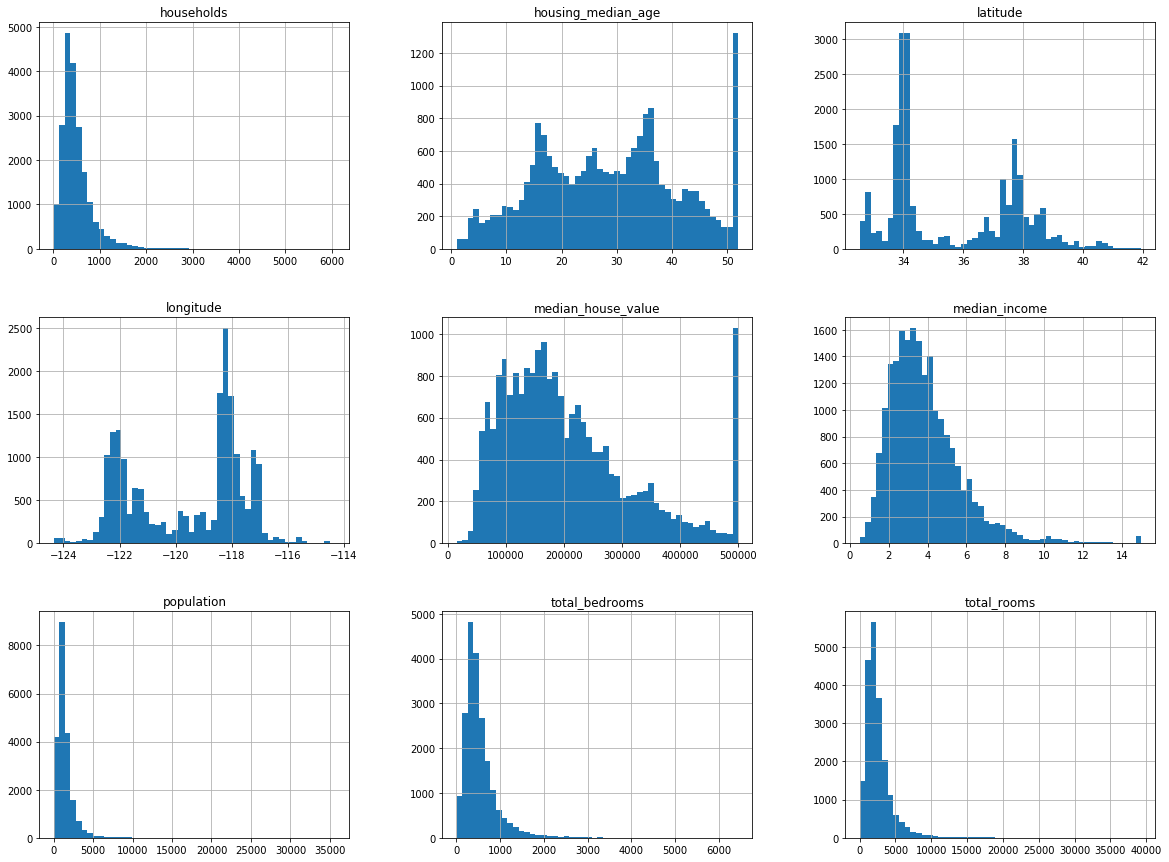

In [6]:
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [7]:
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[test_indices], data.iloc[train_indices]

In [8]:
test_housing, train_housing=split_train_test(housing,0.24221)

In [9]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data,test_ratio,id_column):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:test_set_check(id_,test_ratio))
    return data.loc[~in_test_set] , data.loc[in_test_set]

In [10]:
housing_with_id=housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id,0.2421,'index')

In [11]:
import_train_set,import_test_set = train_test_split(housing,test_size=0.2421,random_state=42)
print(len(import_train_set),len(import_test_set))

15643 4997


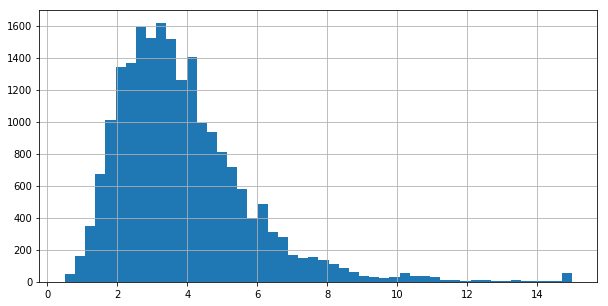

In [12]:
housing.median_income.hist(bins=50, figsize=(10,5))

In [13]:
housing['median_income_cat']=pd.cut(housing['median_income'],
                                   bins=[0,1.5,3.0,4.5,6.0,np.inf],
                                   labels=[1,2,3,4,5])

In [14]:
housing.median_income_cat.value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: median_income_cat, dtype: float64

In [15]:
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing,housing['median_income_cat']):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

In [16]:
strat_test_set['median_income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: median_income_cat, dtype: float64

In [17]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("median_income_cat",axis=1,inplace=True)

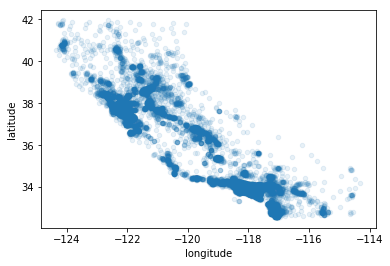

In [18]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

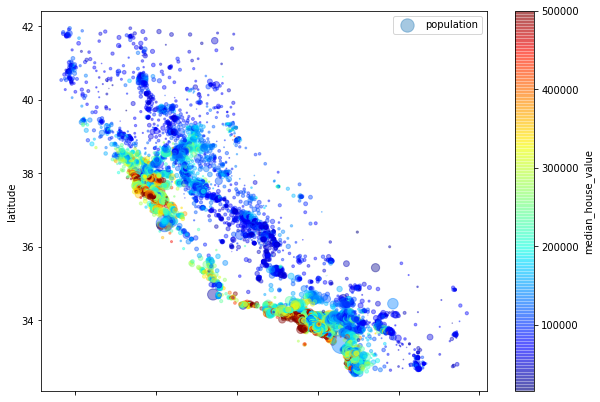

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing['population']/100,label="population",figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()
plt.show()

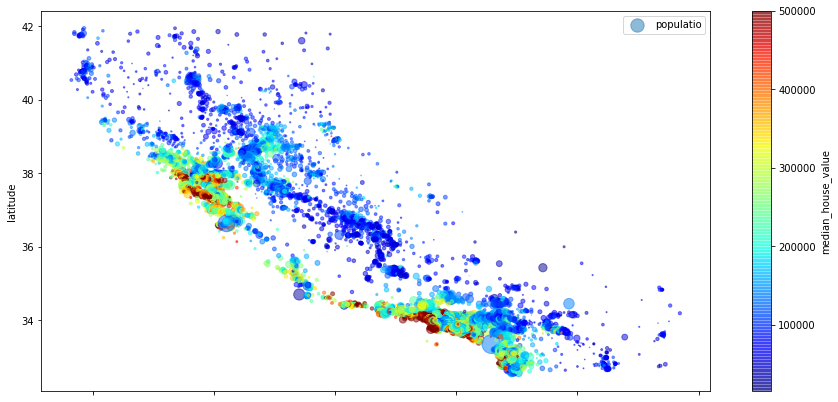

In [20]:
housing.plot(kind='scatter',x="longitude",y="latitude",alpha=0.5,figsize=(15,7),
            s=housing['population']/100,label="populatio",
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()
plt.show()

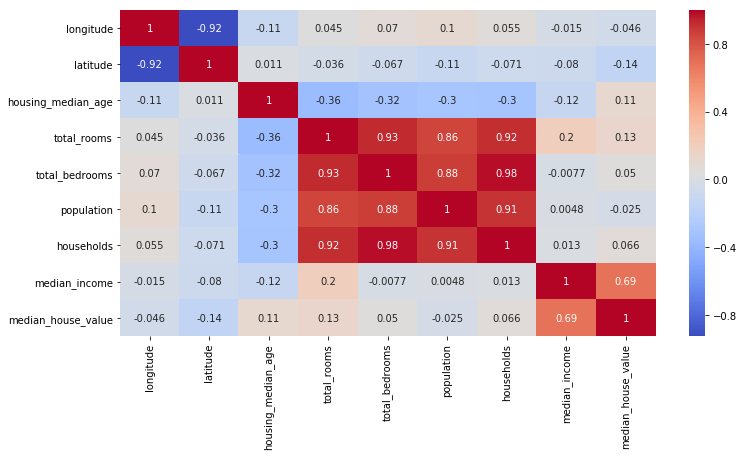

In [21]:
corr_matrix=housing.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns.values,yticklabels=corr_matrix.columns.values,cmap='coolwarm',annot=True)

In [22]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

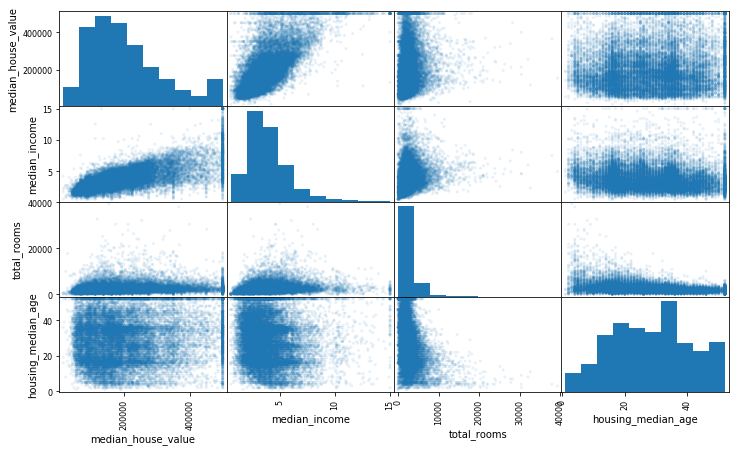

In [23]:
attributes=['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,7),alpha=0.1)
plt.show()

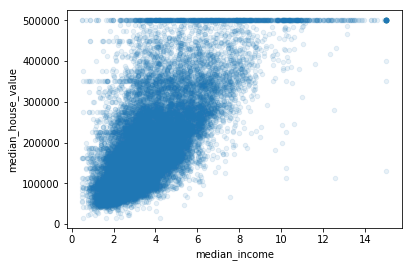

In [24]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

In [25]:
housing[housing.median_house_value==450000].drop_duplicates('ocean_proximity')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat
993,-121.72,37.70,17.0,1671.0,352.0,729.0,252.0,6.1023,450000.0,INLAND,5
4265,-118.32,34.10,28.0,1759.0,716.0,1463.0,620.0,1.7306,450000.0,<1H OCEAN,2
8314,-118.32,33.35,27.0,1675.0,521.0,744.0,331.0,2.1579,450000.0,ISLAND,2
9791,-121.62,36.14,25.0,726.0,274.0,411.0,214.0,3.2375,450000.0,NEAR OCEAN,3
15635,-122.41,37.80,30.0,1821.0,738.0,1648.0,684.0,0.8836,450000.0,NEAR BAY,1


In [26]:
housing["rooms_per_household"]=housing.total_rooms/housing.households
housing["people_per_household"]=housing.population/housing.households
housing["bedrooms_per_houshold"]=housing.total_rooms/housing.total_bedrooms
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,people_per_household,bedrooms_per_houshold
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,6.984127,2.555556,6.821705
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,6.238137,2.109842,6.418626
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,8.288136,2.802260,7.721053
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,5.817352,2.547945,5.421277
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,6.281853,2.181467,5.810714
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,3,4.761658,2.139896,4.314554
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,3,4.931907,2.128405,5.184049
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,3,4.797527,1.788253,4.518195
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,2,4.294118,2.026891,3.842105
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,3,4.970588,2.172269,5.019802


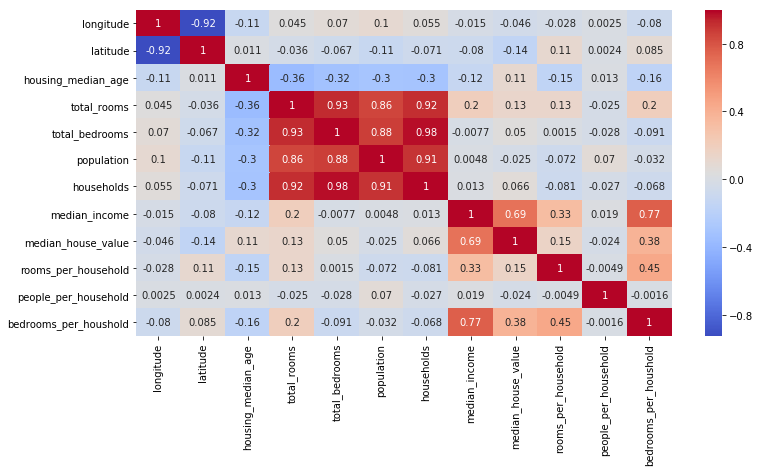

In [27]:
corr_matrix=housing.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix,xticklabels=corr_matrix.columns.values,yticklabels=corr_matrix.columns.values,cmap='coolwarm',annot=True)

In [28]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value       1.000000
median_income            0.688075
bedrooms_per_houshold    0.383920
rooms_per_household      0.151948
total_rooms              0.134153
housing_median_age       0.105623
households               0.065843
total_bedrooms           0.049686
people_per_household    -0.023737
population              -0.024650
longitude               -0.045967
latitude                -0.144160
Name: median_house_value, dtype: float64

In [29]:
housing=strat_train_set.drop("median_house_value",axis="columns")
housing_label=strat_train_set['median_house_value'].copy()

In [30]:
median=housing.total_bedrooms.median()
housing_copy=housing.copy()
housing_copy['total_bedrooms'].fillna(median,inplace=True)

In [31]:
imputer=SimpleImputer(strategy='median')
housing_num=housing.drop('ocean_proximity', axis='columns')
imputer.fit(housing_num)
X=imputer.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns)
housing_tr.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
5,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395
6,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839
7,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000
8,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242
9,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999


In [32]:
housing_cat=housing[['ocean_proximity']]
ordinal_encoder=OrdinalEncoder()
housing_cat_en=ordinal_encoder.fit_transform(housing_cat)

In [33]:
onehot_en=OneHotEncoder()
housing_cat_1hot=onehot_en.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [34]:
total_rooms , total_bedrooms, population, households =3,4,5,6

class combinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household=np.divide(X[:,total_rooms],X[:,households])
        population_per_household=np.divide(X[:,population],X[:,households])
        if(self.add_bedrooms_per_room):
            bedrooms_per_households=np.divide(X[:,total_rooms],X[:,total_bedrooms])
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_households]
        else:
            np.c_[X,rooms_per_household,population_per_household]

In [35]:
attribute_adder=combinedAttributeAdder(add_bedrooms_per_room=True)
household_attributes=attribute_adder.fit_transform(housing.values)
household_attributes

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422, 2.094395280235988,
        4.467236467236467],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 2.7079646017699117,
        6.287037037037037],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 2.0259740259740258,
        4.144373673036093],
       ...,
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 2.742483660130719,
        5.567660550458716],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 3.808988764044944,
        5.157894736842105],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 1.9859154929577465,
        4.538123167155425]], dtype=object)

In [39]:
std_scale=StandardScaler()
housing_std_scale=std_scale.fit_transform(housing.iloc[:,:-1])
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


In [38]:
transform_num_pipeline=Pipeline([('imputer',SimpleImputer(strategy='median')),
                           ('attribute_adder',combinedAttributeAdder()),
                           ('std_scaler',StandardScaler())
                            ])
num_attributes=list(housing_num)
cat_attributes=['ocean_proximity']

full_pipeline=ColumnTransformer([('num',transform_num_pipeline,num_attributes),
                                 ('cat',OneHotEncoder(),cat_attributes)])

housing_prepared=full_pipeline.fit_transform(housing)
#pd.DataFrame(housing_prepared, columns=list(housing_num.columns)+['rooms_per_household','population_per_household','bedrooms_per_households']+list(housing.ocean_proximity.unique()))

In [ ]:
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_label)
pd.DataFrame(housing_prepared).head()

In [ ]:
some_data=housing.iloc[:10000]
some_label=housing_label.iloc[:10000]
some_data_prepared=full_pipeline.fit_transform(some_data)
print(lin_reg.predict(some_data_prepared)[:4])
print(list(some_label)[:5])

In [1]:
housing

NameError: name 'housing' is not defined

In [42]:
new_num_pipeline=Pipeline([('imputer',SimpleImputer(strategy='mean')),
                           ('attr_adder',combinedAttributeAdder()),
                          ('std_scaler',StandardScaler())])
new_fullpipeline=ColumnTransformer([('num',new_num_pipeline,list(housing_num.columns)),
                                  ('cat',OneHotEncoder(),['ocean_proximity'])])
housing_raw_prepared=new_fullpipeline.fit_transform(housing)

lm=LinearRegression()
lm.fit(housing_raw_prepared,housing_label)

housing_prediction=lm.predict(housing_raw_prepared)
lin_mse=mean_squared_error(housing_label,housing_prediction)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

68684.19080660283

In [44]:
housing_raw_prepared.shape

(16512, 16)

In [547]:
tree_reg=DecisionTreeRegressor()
housing_fit=tree_reg.fit(housing_prepared,housing_label)
housing_predict=tree_reg.predict(housing_prepared)
tree_rmse=np.sqrt(mean_squared_error(housing_label,housing_predict))
tree_rmse

0.0

In [560]:
scores=cross_val_score(tree_reg,
                      housing_prepared,
                      housing_label,
                      scoring='neg_mean_squared_error',
                      cv=10)
tree_rmse_scores=np.sqrt(-scores)

In [554]:
def display_scores(scores):
    print(f"Scores:{scores}\nMean Score:{scores.mean()}\nStd. Dev:{scores.std()}")

In [561]:
display_scores(tree_rmse_scores)

Scores:[68175.50061107 68340.53543353 69163.0107062  68600.38358066
 70299.22342283 74692.14591871 71214.88140335 70581.81259512
 78227.24490374 70316.30237673]
Mean Score:70961.10409519555
Std. Dev:3020.1440966915598


In [563]:
lm_scores=cross_val_score(lin_reg,
                         housing_prepared,
                         housing_label,
                         scoring="neg_mean_squared_error",
                         cv=10)
lin_reg_rmse=np.sqrt(-lm_scores)

In [567]:
display_scores(lin_reg_rmse)

Scores:[67016.03042064 67128.67109626 68051.68782637 74860.77896327
 68456.85856405 71477.5050075  65130.1004029  68492.97827394
 71779.07637352 67967.00158847]
Mean Score:69036.0688516917
Std. Dev:2704.248553371778


In [581]:
random_forest=RandomForestRegressor()
random_forest.fit(housing_prepared,housing_label)
random_forest_rmse=np.sqrt(mean_squared_error(housing_label,random_forest.predict(housing_prepared)))

scores=cross_val_score(random_forest,
                      housing_prepared,
                      housing_label,
                      scoring="neg_mean_squared_error",
                      cv=10)
random_forest_rmse=np.sqrt(-scores)

display_scores(random_forest_rmse)

joblib.dump(random_forest_rmse,"random_forest_rmse.pkl")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores:[53482.08846388 50478.66404659 52930.23832708 54256.70250266
 51516.24695053 56060.01767479 51028.90829461 50208.53941805
 55452.51138327 52248.50491378]
Mean Score:52766.24219752343
Std. Dev:1935.1880520797672


['random_forest_rmse.pkl']

Scores:[53482.08846388 50478.66404659 52930.23832708 54256.70250266
 51516.24695053 56060.01767479 51028.90829461 50208.53941805
 55452.51138327 52248.50491378]
Mean Score:52766.24219752343
Std. Dev:1935.1880520797672
